In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../scripts') # adjust the path based on actual location
from quantitative_analysis import StockAnalyzer


In [11]:
# Load your CSV

tsla_price_data = pd.read_csv('../src/data/yfinance_data/TSLA_historical_data.csv')
# Create analyzer object

tsla_analyzer = StockAnalyzer(tsla_price_data )
# Prepare data
tsla_analyzer.prepare_data()


First few rows of the dataset:
         Date      Open      High       Low     Close  Adj Close     Volume  \
0  2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
1  2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2  2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
3  2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
4  2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  

Missing values in each column:
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Datetime conversion and index set completed.


In [ ]:
tsla_analyzer.add_technical_indicators()

In [ ]:
tsla_analyzer.plot_indicators()

In [ ]:
tsla_analyzer.plot_candlestick()

In [ ]:
tsla_analyzer.plot_volume()

Correlation analysis 

In [12]:
# Load sentiment CSV
sentiment_df = pd.read_csv("../src/sentiment_with_polarity.csv")

# Filter for a specific ticker
sentiment_df = sentiment_df[sentiment_df['stock'] == 'TSLA']

print(f"✅ Sentiment data cleaned. Rows remaining: {len(sentiment_df)}")


✅ Sentiment data cleaned. Rows remaining: 1875


In [ ]:
# Get stock price DataFrame from your StockAnalyzer
stock_df = tsla_analyzer.df.copy()

# If 'Date' is a column
if 'Date' in stock_df.columns:
    print("📌 'Date' column dtype:", stock_df['Date'].dtype)
else:
    print("🕓 'Date' is not a column. Checking index...")
    print("📌 Index dtype:", stock_df.index.dtype)

# Check if all datetime values have time set to midnight
all_normalized = (stock_df.index.time == pd.to_datetime("00:00:00").time())

if all_normalized.all():
    print("✅ All dates are normalized (00:00:00).")
else:
    print("⚠️ Some dates are not normalized. Example non-normalized rows:")
    print(stock_df[~all_normalized].head())



In [13]:
# 1. Filter  sentiment
sentiment_df = sentiment_df[sentiment_df['stock'] == 'TSLA']
daily_sentiment = sentiment_df.groupby('date')['polarity'].mean().to_frame()

# 2. Load and filter stock data
stock_df = tsla_analyzer.df.copy()
stock_df['return'] = stock_df['Close'].pct_change() * 100
daily_returns = stock_df[['return']]

# 3. Normalize both indexes
daily_sentiment.index = pd.to_datetime(daily_sentiment.index).normalize()
daily_returns.index = pd.to_datetime(daily_returns.index).normalize()

# 4. Filter stock data to match sentiment range
start_date = daily_sentiment.index.min()
end_date = daily_sentiment.index.max()
daily_returns = daily_returns.loc[start_date:end_date]

# 5. Merge and correlate
merged_df = pd.merge(daily_sentiment, daily_returns, left_index=True, right_index=True, how='inner')
correlation = merged_df['polarity'].corr(merged_df['return'])

# 6. Output
print("📅 Sentiment dates:", start_date, "→", end_date)
print(f"🧮 Merged rows: {len(merged_df)}")
print("\n📄 Sample merged data:\n", merged_df.head())
print(f"\n📊 Correlation between AAPL sentiment and return: {correlation:.4f}")


📅 Sentiment dates: 2019-07-01 00:00:00 → 2020-06-10 00:00:00
🧮 Merged rows: 230

📄 Sample merged data:
             polarity    return
2019-07-01  0.079167  1.660254
2019-07-02  0.102083 -1.153320
2019-07-03  0.058144  4.609216
2019-07-05  0.166667 -0.766283
2019-07-08  0.000000 -1.184041

📊 Correlation between AAPL sentiment and return: 0.0827


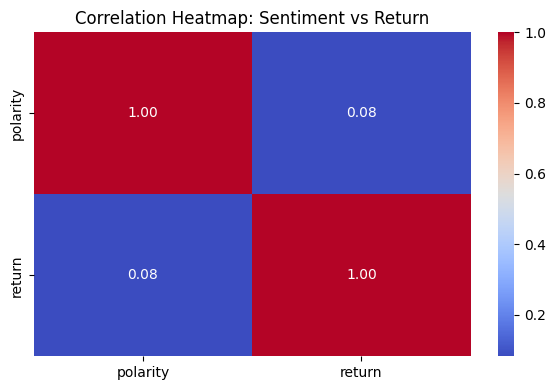

In [14]:
# Compute correlation matrix
corr_matrix = merged_df.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Sentiment vs Return")
plt.tight_layout()
plt.show()

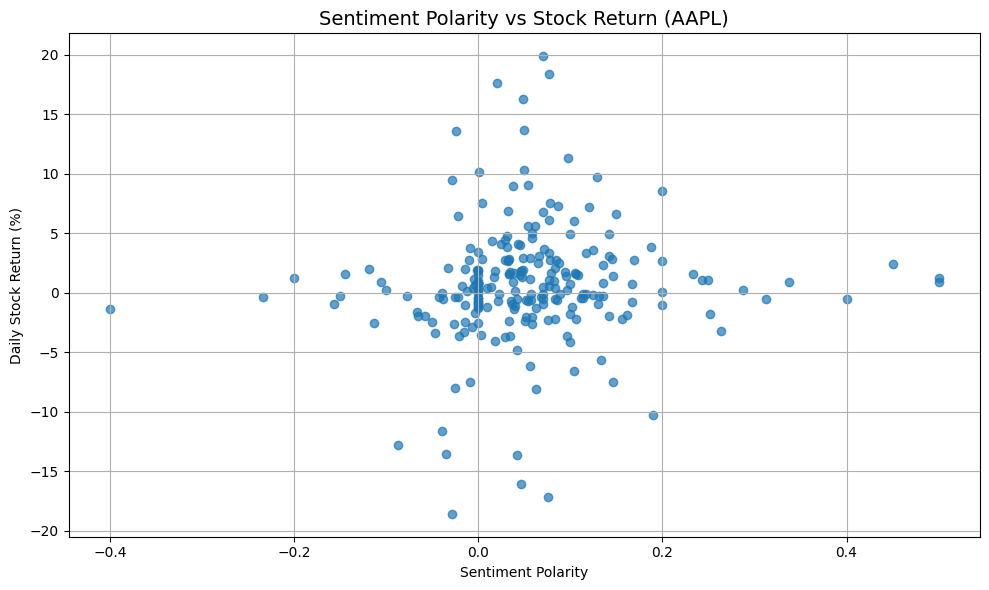

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['polarity'], merged_df['return'], alpha=0.7)
plt.title('Sentiment Polarity vs Stock Return (AAPL)', fontsize=14)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Daily Stock Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()